*After days of learning about object detectiona and cnns , I spent many days implementing and removing errors . The task invloves multi-class and multi bboxes which can be quite complex to handle the ouput and loss functions. Still, one error I couldn't resolve. So till whatever endpoint I reached , I have uploaded the file :)*

IMPORT NECESSARY MODULES

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.patches as patches

**LOAD THE DATASET**
*   We use tensorflow datasets api and tfds.load() which is a thin wrapper around the tfds.build api
*   Train and validation data are loaded along with information about the voc 2007 dataset

**WHY VOC 2007 ?**


*   The voc 2012 is broken in tfds api and also manually downloading it is corrupted
*   Coco and open images are huge to perform local computation






In [2]:
(train_dataset,val_dataset), info = tfds.load('voc/2007', split=['train', 'validation'], with_info=True)

The data set contains elements which have a features dictionary defined in the next code cell

**Explanation of revelent features :**

* image : tf.Tensor of type tf.uint8 and shape [height, width, num_channels]

* image/filename : name of the image file

* labels : tf.Tensor of type tf.int64 and shape [presentLabel1,PresentLabel2,....]

* labels_no_difficult : labels which are not difficult to recognize

*objects* : sequence of sub-features
    

*   bbox : tf.Tensor of type tf.float32 and shape [num_of_boxes,4]
*   label : tf.Tensor of type int64 and shape  
[
presentLabel1_1,presentLabel1_2,.....
presentLabel2_1,presentLabel2_2....
]



In [3]:
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'labels': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=20)),
    'labels_no_difficult': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=20)),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'is_difficult': bool,
        'is_truncated': bool,
        'label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'pose': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
})

Since this a multi-object in one image model we need to fix max_objects in each image for ease of use

In [4]:
IMG_SIZE = 128
MAX_OBJECTS = 10

**preprocess function**:

  takes an element from the dataset and


*   resizes and normalizes the image
*   returns the image tensor and a dictionary with two key-value pairs containg the class labels and bboxes of the element



**prepare_targets function**


*   Pads label and bboxes to ensure fixed number of objects for ease of use
*   returns image and a dictionary with padded labels and bboxes



In [5]:
def preprocess(data):
    # Resize and normalize the images
    image = tf.image.resize(data['image'], (IMG_SIZE, IMG_SIZE)) / 255.0
    labels = data['objects']['label']
    bboxes = data['objects']['bbox']
    return image, {'class_output': labels, 'bbox_output': bboxes}

def prepare_targets(image, target):
    labels = target['class_output']
    bboxes = target['bbox_output']
    num_objects = tf.shape(labels)[0]
    # Pad labels and bounding boxes to ensure a fixed number of objects
    padded_labels = tf.pad(labels, [[0, MAX_OBJECTS - num_objects]], constant_values=-1)
    padded_bboxes = tf.pad(bboxes, [[0, MAX_OBJECTS - num_objects], [0, 0]], constant_values=0)
    return image, {'class_output': padded_labels, 'bbox_output': padded_bboxes}

**DATA EXPLORATION**

  plot the image and bboxes using matplotlib

   ERROR:
   
   Since the bbox coordinates are already normalised , I needed to denormalize them and extract width height from it


In [6]:
def plot_image_with_bboxes(example):
    image = tf.image.resize(example['image'], (IMG_SIZE, IMG_SIZE)) / 255.0
    labels = example['objects']['label']
    bboxes = example['objects']['bbox']
    print(example['objects']['label'])
    # Plot the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Add bounding boxes to the image
    for bbox in bboxes:
        # Bounding box coordinates are normalized (0,1)
        ymin, xmin, ymax, xmax = bbox
        x = xmin * IMG_SIZE
        y = ymin * IMG_SIZE
        width = (xmax - xmin) * IMG_SIZE
        height = (ymax - ymin) * IMG_SIZE

        # Create a rectangle patch
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

tf.Tensor([12 14 12 14], shape=(4,), dtype=int64)


tf.Tensor([6 6], shape=(2,), dtype=int64)


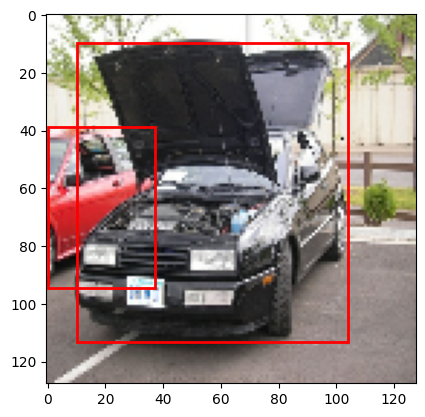

tf.Tensor([2], shape=(1,), dtype=int64)


tf.Tensor([16], shape=(1,), dtype=int64)


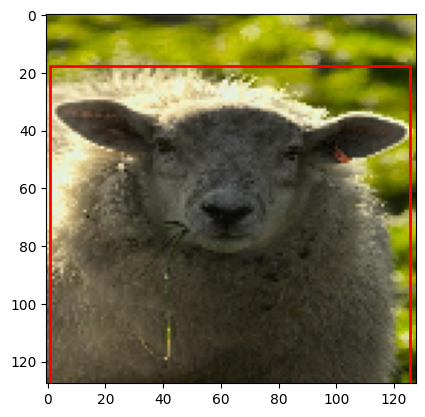

tf.Tensor([18], shape=(1,), dtype=int64)


In [7]:
for example in train_dataset.take(5):
    plot_image_with_bboxes(example)

map the preprocess and prepare_targets function to train_dataset

In [8]:
train_dataset = train_dataset.map(preprocess).map(prepare_targets).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).map(prepare_targets).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

The model structure is given below as an image also defined here :

1.  **Input Layer**:

  Defines the input layer with the shape (IMG_SIZE, IMG_SIZE, 3),
  where IMG_SIZE is the size of the resized images (128 in this case) and 3 corresponds to the RGB color channels.

2.  **Convolutional and Pooling Layers:**

  * *First Convolutional Layer*:
  
  Applies 32 filters of size (3, 3) with ReLU activation, followed by a max-pooling layer that downsamples the feature maps by a factor of 2.
  * *Second Convolutional Layer*:
  
   Applies 64 filters of size (3, 3) with ReLU activation, followed by a max-pooling layer that downsamples the feature maps by a factor of 2.
  * *Third Convolutional Layer*:
  
  Applies 128 filters of size (3, 3) with ReLU activation, followed by a max-pooling layer that downsamples the feature maps by a factor of 2.

  These layers help in extracting hierarchical features from the images, capturing spatial hierarchies.

3.  **Flatten Layer:**

  Flattens the 3D tensor output from the last convolutional layer into a 1D tensor, preparing it for the fully connected (dense) layer.

4.  **Dense Layer:**

  A fully connected layer with 256 units and ReLU activation. This layer combines all the features extracted by the convolutional layers and prepares them for the final output layers.

5.  **Class Output:**

  Dense Layer for Class Output: This layer has num_classes * MAX_OBJECTS units with softmax activation. It predicts the class probabilities for each of the MAX_OBJECTS objects in the image.
  Reshape Layer: Reshapes the output to (MAX_OBJECTS, num_classes), where each object has num_classes class probabilities.
  Naming: The layer is named 'class_output' to identify it clearly when using loss functions and metrics.

6.  **Bounding Box Output:**

  Dense Layer for Bounding Box Output: This layer has 4 * MAX_OBJECTS units with sigmoid activation. It predicts the bounding box coordinates (ymin, xmin, ymax, xmax) for each of the MAX_OBJECTS objects.
  Reshape Layer: Reshapes the output to (MAX_OBJECTS, 4), where each object has 4 bounding box coordinates.
  Naming: The layer is named 'bbox_output' to identify it clearly when using loss functions and metrics.

7.  **Model Definition:**

  Combines the inputs and the two output branches (class_output and bbox_output) into a single Keras model.
  The model is returned for further compilation and training.

In [9]:
def build_model(num_classes):
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)

    # Outputs for class labels
    class_output = tf.keras.layers.Dense(num_classes * MAX_OBJECTS, activation='softmax')(x)
    class_output = tf.keras.layers.Reshape((MAX_OBJECTS, num_classes), name='class_output')(class_output)

    # Outputs for bounding box coordinates
    bbox_output = tf.keras.layers.Dense(4 * MAX_OBJECTS, activation='sigmoid')(x)
    bbox_output = tf.keras.layers.Reshape((MAX_OBJECTS, 4), name='bbox_output')(bbox_output)

    model = tf.keras.models.Model(inputs=inputs, outputs=[class_output, bbox_output])
    return model

In [10]:
num_classes = info.features['objects']['label'].num_classes
model = build_model(num_classes)

In [11]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=1000,
    show_layer_activations=True,
    show_trainable=True,
)

**custom_loss function:**
1. Extracting True and Predicted Values:

y_true is a dictionary containing the true values for the class labels (class_output) and the bounding boxes (bbox_output).
y_pred is a dictionary containing the predicted values for the class labels (class_output) and the bounding boxes (bbox_output).

2. Creating a Mask for Valid Labels:

The mask is a boolean tensor that indicates the positions of valid class labels. In this context, -1 is used to indicate padding (or invalid labels), so the mask will be True where the class label is not -1.

3. Calculating the Class Loss:

tf.keras.losses.SparseCategoricalCrossentropy() computes the sparse categorical cross-entropy loss between the true and predicted class labels.
class_true[mask] and class_pred[mask] are used to select only the valid class labels and their corresponding predictions, ignoring the padded values.

4. Calculating the Bounding Box Loss:

tf.keras.losses.MeanSquaredError() computes the mean squared error (MSE) loss between the true and predicted bounding box coordinates.

5. Combining the Losses:

The function returns the sum of the class loss and the bounding box loss. This combined loss will be used to optimize the model during training.

In [15]:
def custom_loss(y_true, y_pred):
    class_true, bbox_true = y_true['class_output'], y_true['bbox_output']
    class_pred, bbox_pred = y_pred['class_output'], y_pred['bbox_output']
    # Mask for valid labels
    mask = tf.not_equal(class_true, -1)
    class_loss = tf.keras.losses.SparseCategoricalCrossentropy()(class_true[mask], class_pred[mask])
    bbox_loss = tf.keras.losses.MeanSquaredError()(bbox_true, bbox_pred)
    return class_loss + bbox_loss

In [16]:
model.compile(optimizer='adam', loss=custom_loss, metrics={'class_output': 'accuracy', 'bbox_output': 'mse'})

I couldn't fix the following error.

My hypothesis : This error somehow indicates that y_true and y_pred are not dictionaries , but since I have mapped the train_dataset to have images,{class_output,bbox_output} , it should responf to those keys. I am frustrated at this error :(

In [17]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "<ipython-input-15-2aa6a16f4e2d>", line 2, in custom_loss  *
        class_true, bbox_true = y_true['class_output'], y_true['bbox_output']

    TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'class_output'
